https://github.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/blob/main/HOTSAP_SARIMAX.ipynb

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import weibull_min
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [42]:
folder_path = ""
df = pd.read_csv(folder_path, sep='\t')

In [43]:
df[0:144]

,Index,WF,DATE,WT,ActivePower,WindSpeed
0,4,ARGANIL,2019-11-01 00:00:00,5,2060.42500,12.70263
1,22,ARGANIL,2019-11-01 00:10:00,5,2057.55000,13.21053
2,40,ARGANIL,2019-11-01 00:20:00,5,2050.05263,13.51282
3,58,ARGANIL,2019-11-01 00:30:00,5,2032.70000,12.54750
4,76,ARGANIL,2019-11-01 00:40:00,5,2059.79487,12.83250
...,...,...,...,...,...,...
139,2506,ARGANIL,2019-11-01 23:10:00,5,2057.05128,16.34103
140,2524,ARGANIL,2019-11-01 23:20:00,5,2058.18919,14.31316
141,2542,ARGANIL,2019-11-01 23:30:00,5,2055.48718,13.98000
142,2560,ARGANIL,2019-11-01 23:40:00,5,2054.28947,14.96154


In [44]:
df.drop(['WF', 'WT', 'Index','DATE'], axis=1, inplace=True)

# 1 day of data

In [7]:
def optimize_SARIMAX(endog, exog, parameters_list, d, D, s):
    """
        Returns dataframe with parameters, corresponding AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list with (p, d, P, Q)tuples
        d - integration order
        D - seasonal integration order
        s - length of the season
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(endog,
                           exog,
                           order=(param[0], d, param[1]),
                           seasonal_order=(param[2], D, param[3], s),
                           simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 6

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [33]:
endog = df["ActivePower"][:144] # data from 5 days. lets give the model data from 1 day only
exog = df["WindSpeed"][:144]

In [35]:
result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 6)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 0, 0)",1803.699647
1,"(2, 2, 0, 0)",1804.308915
2,"(3, 3, 1, 0)",1805.646629
3,"(0, 2, 2, 0)",1805.647820
4,"(3, 3, 0, 1)",1805.840084
...,...,...
251,"(0, 1, 3, 3)",1818.608450
252,"(1, 0, 3, 3)",1818.947556
253,"(0, 0, 0, 0)",1819.141345
254,"(0, 1, 0, 0)",1820.073469


In [36]:
best_model = SARIMAX(endog, 
                     exog, 
                     order=(3,1,3), 
                     seasonal_order=(0,0,0,6),
                    simple_differencing=False)
res = best_model.fit(dis=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            ActivePower   No. Observations:                  144
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -893.850
Date:                Mon, 17 Jul 2023   AIC                           1803.700
Time:                        11:56:17   BIC                           1827.402
Sample:                             0   HQIC                          1813.331
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WindSpeed     23.1191      8.469      2.730      0.006       6.521      39.717
ar.L1          0.9050      0.077     11.790      0.000       0.755       1.055
ar.L2         -0.9602      0.072    -13.286      0.0

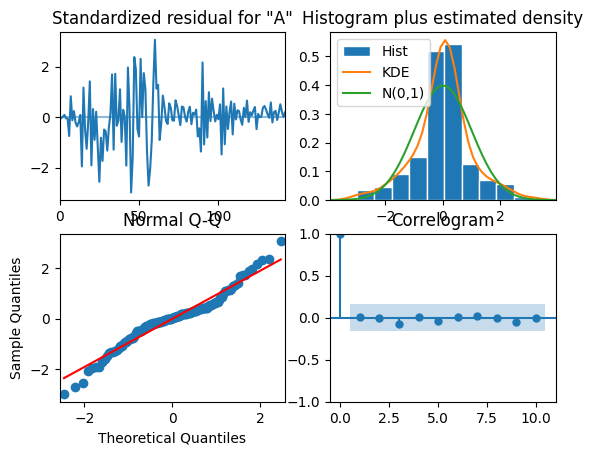

In [37]:
res.plot_diagnostics();

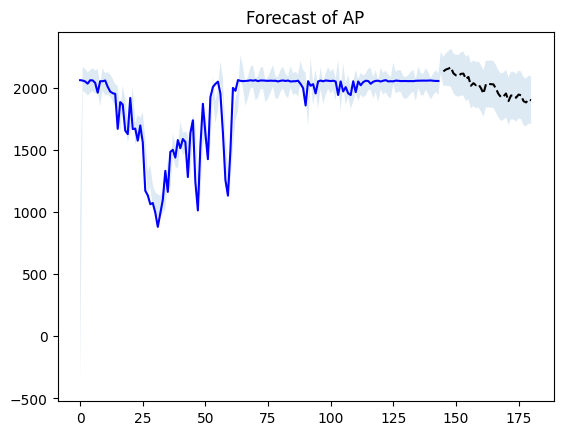

In [39]:
n_forecast = 36
predict = res.get_prediction(end=best_model.nobs + n_forecast,
                            exog = exog.iloc[-37:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(df["ActivePower"][:144], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)

ax.set_title('Forecast of AP')
plt.show()

In [19]:
len(predict.predicted_mean)

637

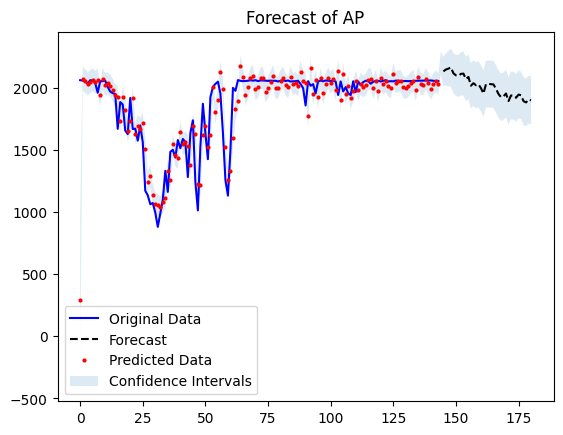

In [45]:
fig, ax = plt.subplots()
ax.plot(df["ActivePower"][:144], color='blue', label='Original Data')


ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--', label= "Forecast")


ax.plot(predict.predicted_mean[:144], 'ro',markersize=2, label='Predicted Data' ) # red dots 
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15, label='Confidence Intervals')
#ax.set_xlim(190,199)
#ax.set_ylim(13000, 14100)
ax.legend()
ax.set_title('Forecast of AP')
plt.show()

In [46]:
mse = mean_squared_error(df["ActivePower"][:144], predict.predicted_mean[:144])

print(f'MSE: {mse}')

MSE: 37184.96817886404


In [47]:
mape = np.mean(np.abs(df["ActivePower"][:144] - predict.predicted_mean[:144]) / np.abs(df["ActivePower"][:144]))

print(f'MAPE: {round(mape * 100, 2)}%')

MAPE: 5.89%


# Let's predict WindSpeed based on AP

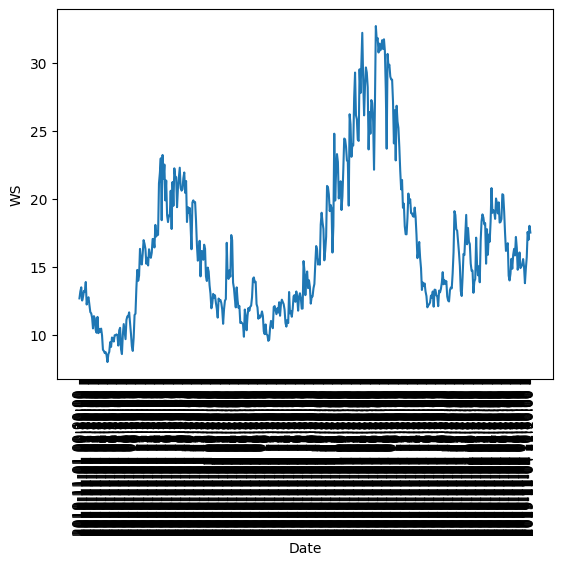

In [19]:
folder_path = ""
df = pd.read_csv(folder_path, sep='\t')
plt.plot(df['DATE'][:500], df['WindSpeed'][:500])
plt.title('')
plt.ylabel('WS')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

In [48]:
# lets change 
exog = df["ActivePower"][:144]
endog = df["WindSpeed"][:144]

In [49]:
result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 6)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 2, 0, 0)",431.451889
1,"(3, 0, 0, 0)",435.586255
2,"(3, 2, 0, 1)",436.415709
3,"(3, 2, 1, 0)",436.571213
4,"(3, 1, 0, 0)",436.934709
...,...,...
251,"(0, 0, 2, 0)",467.757660
252,"(0, 0, 3, 2)",470.999300
253,"(0, 0, 0, 0)",471.694606
254,"(0, 0, 0, 1)",473.086653


In [50]:
best_model = SARIMAX(endog, 
                     exog, 
                     order=(3,1,2), 
                     seasonal_order=(0,0,0,6),
                    simple_differencing=False)
res = best_model.fit(dis=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              WindSpeed   No. Observations:                  144
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -208.726
Date:                Mon, 17 Jul 2023   AIC                            431.452
Time:                        12:01:57   BIC                            452.192
Sample:                             0   HQIC                           439.880
                                - 144                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ActivePower     0.0029      0.001      3.384      0.001       0.001       0.005
ar.L1          -1.2112      0.075    -16.125      0.000      -1.358      -1.064
ar.L2          -1.1615      0.088    -13.158    

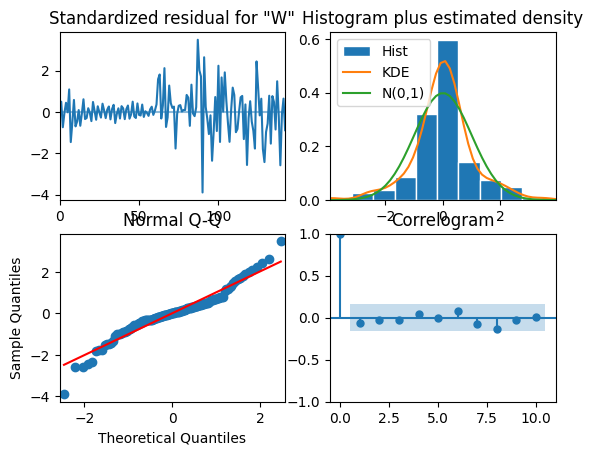

In [51]:
res.plot_diagnostics();

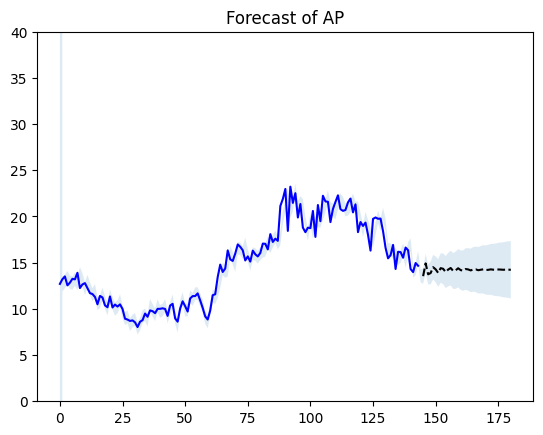

In [52]:
n_forecast = 36
predict = res.get_prediction(end=best_model.nobs + n_forecast,
                            exog = exog.iloc[-37:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(df["WindSpeed"][:144], color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)
ax.set_ylim(0, 40)
ax.set_title('Forecast of AP')
plt.show()

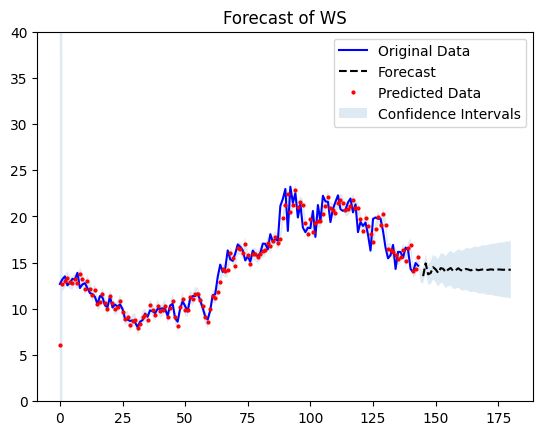

In [53]:
fig, ax = plt.subplots()
ax.plot(df["WindSpeed"][:144], color='blue', label='Original Data')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--', label= "Forecast")
ax.plot(predict.predicted_mean[:144], 'ro',markersize=2, label='Predicted Data' ) # red dots 
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15, label='Confidence Intervals')
ax.set_ylim(0, 40)
ax.legend()
ax.set_title('Forecast of WS')
plt.show()

In [55]:
mse = mean_squared_error(df["WindSpeed"][:144], predict.predicted_mean[:144])

print(f'MSE: {mse}')

MSE: 1.3738818886327342


In [56]:
mape = np.mean(np.abs(df["WindSpeed"][:144] - predict.predicted_mean[:144]) / np.abs(df["WindSpeed"][:144]))

print(f'MAPE: {round(mape * 100, 2)}%')

MAPE: 4.82%


# 1 month of data

Predict AP

In [57]:
endog = df["ActivePower"][:4320] 
exog = df["WindSpeed"][:4320]

In [58]:
result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 6)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 1, 0)",55608.213218
1,"(3, 3, 0, 1)",55610.076723
2,"(3, 3, 1, 1)",55610.170511
3,"(2, 3, 2, 0)",55610.532520
4,"(3, 3, 2, 0)",55610.574271
...,...,...
251,"(0, 0, 0, 1)",55898.875650
252,"(0, 0, 2, 0)",55899.272016
253,"(0, 0, 0, 2)",55899.372702
254,"(0, 0, 2, 2)",55900.817872


In [59]:
best_model = SARIMAX(endog, 
                     exog, 
                     order=(3,1,3), 
                     seasonal_order=(1,0,0,6),
                    simple_differencing=False)
res = best_model.fit(dis=False)

print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        ActivePower   No. Observations:                 4320
Model:             SARIMAX(3, 1, 3)x(1, 0, [], 6)   Log Likelihood              -27795.107
Date:                            Mon, 17 Jul 2023   AIC                          55608.213
Time:                                    15:55:57   BIC                          55665.550
Sample:                                         0   HQIC                         55628.459
                                           - 4320                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WindSpeed     36.4137      1.077     33.805      0.000      34.302      38.525
ar.L1         -0.1733      0.054   

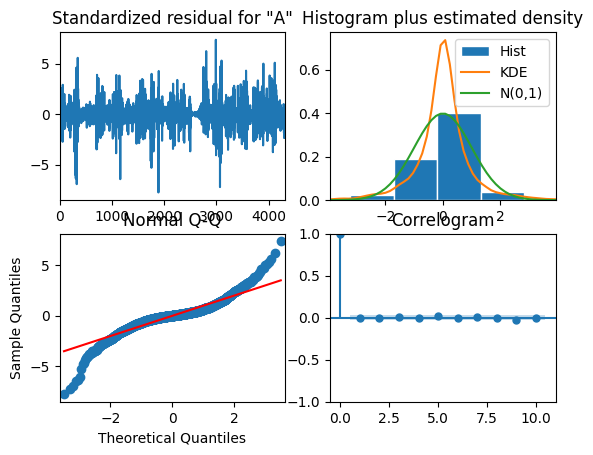

In [60]:
res.plot_diagnostics();

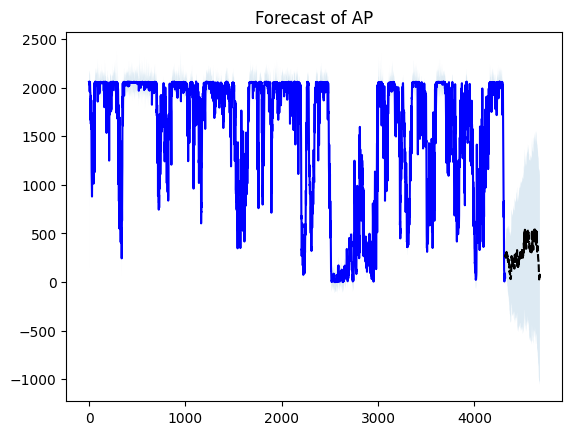

In [64]:
n_forecast = 360
predict = res.get_prediction(end=best_model.nobs + n_forecast,
                            exog = exog.iloc[-361:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(df["ActivePower"][:4320] , color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)

ax.set_title('Forecast of AP')
plt.show()

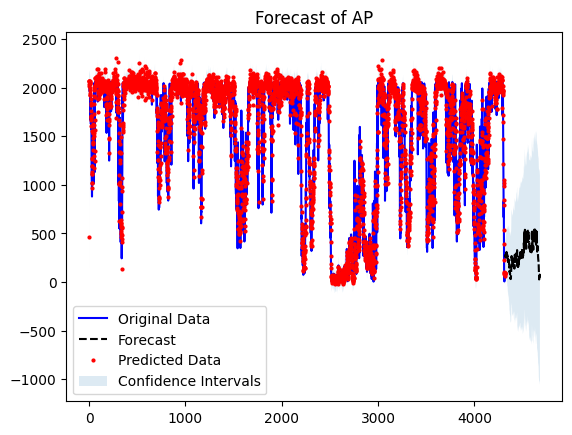

In [65]:
fig, ax = plt.subplots()
ax.plot(df["ActivePower"][:4320], color='blue', label='Original Data')


ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--', label= "Forecast")


ax.plot(predict.predicted_mean[:4320], 'ro',markersize=2, label='Predicted Data' ) # red dots 
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15, label='Confidence Intervals')
#ax.set_xlim(190,199)
#ax.set_ylim(13000, 14100)
ax.legend()
ax.set_title('Forecast of AP')
plt.show()

In [66]:
mse = mean_squared_error(df["ActivePower"][:4320], predict.predicted_mean[:4320])

print(f'MSE: {mse}')

MSE: 23355.00502509864


In [69]:
mape = np.mean(np.abs(df["ActivePower"][:4320] - predict.predicted_mean[:4320]) / np.abs(df["ActivePower"][:4320]))

print(f'MAPE: {round(mape * 100, 2)}%')

MAPE: inf%


Predict WS

In [70]:
exog = df["ActivePower"][:4320] 
endog = df["WindSpeed"][:4320] 

In [71]:
result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 6)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 0, 0)",13029.703849
1,"(1, 1, 1, 0)",13031.693627
2,"(1, 1, 0, 1)",13031.707005
3,"(2, 1, 0, 0)",13031.858143
4,"(1, 2, 0, 0)",13032.607188
...,...,...
251,"(0, 0, 2, 2)",13386.961955
252,"(0, 0, 1, 3)",13387.100571
253,"(0, 0, 3, 2)",13388.382894
254,"(0, 0, 2, 3)",13389.108454


In [72]:
best_model = SARIMAX(endog, 
                     exog, 
                     order=(1,1,1), 
                     seasonal_order=(0,0,0,6),
                    simple_differencing=False)
res = best_model.fit(dis=False)

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              WindSpeed   No. Observations:                 4320
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6510.852
Date:                Mon, 17 Jul 2023   AIC                          13029.704
Time:                        16:28:49   BIC                          13055.187
Sample:                             0   HQIC                         13038.702
                               - 4320                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ActivePower     0.0020   7.35e-05     26.620      0.000       0.002       0.002
ar.L1           0.3809      0.024     15.677      0.000       0.333       0.429
ma.L1          -0.6516      0.021    -30.642    

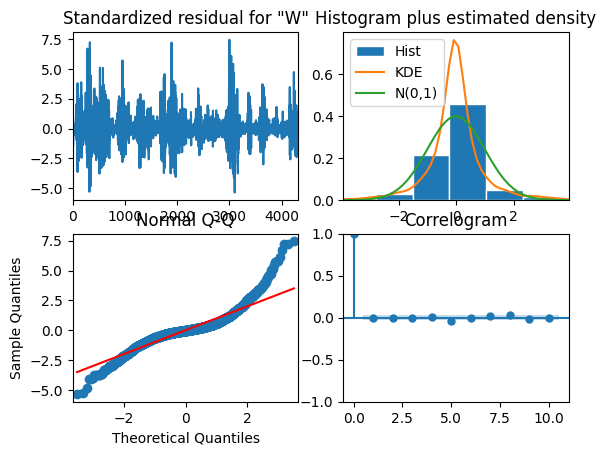

In [73]:
res.plot_diagnostics();

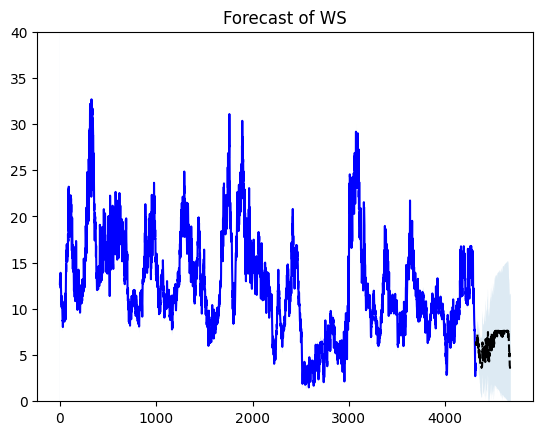

In [75]:
n_forecast = 360
predict = res.get_prediction(end=best_model.nobs + n_forecast,
                            exog = exog.iloc[-361:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

fig, ax = plt.subplots()
ax.plot(df["WindSpeed"][:4320] , color='blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15)
ax.set_ylim(0, 40)
ax.set_title('Forecast of WS')
plt.show()

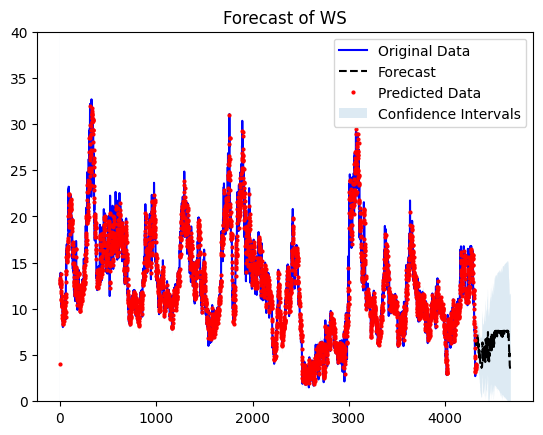

In [77]:
fig, ax = plt.subplots()
ax.plot(df["WindSpeed"][:4320] , color='blue', label='Original Data')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--', label= "Forecast")
ax.plot(predict.predicted_mean[:4320] , 'ro',markersize=2, label='Predicted Data' ) # red dots 
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.15, label='Confidence Intervals')
ax.set_ylim(0, 40)
ax.legend()
ax.set_title('Forecast of WS')
plt.show()

In [78]:
mse = mean_squared_error(df["WindSpeed"][:4320] , predict.predicted_mean[:4320] )

print(f'MSE: {mse}')

MSE: 1.2108586827089354


In [79]:
mape = np.mean(np.abs(df["WindSpeed"][:4320] - predict.predicted_mean[:4320] ) / np.abs(df["WindSpeed"][:4320] ))

print(f'MAPE: {round(mape * 100, 2)}%')

MAPE: 5.37%
